In [3]:
import torch
from torch import nn 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

torch.__version__

'2.5.1+cpu'

## Pytorch Workflow

Let's explore a PyTorch end-to-end workflow.


In [2]:
what_we_are_covering = { 
                        1: "data (prepare and load)",
                        2: "build model",
                        3: "fitting the model to data (training)",
                        4: "making predictions and evaluating a model (inference)",
                        5: "saving and loading a model",
                        6: "putting it all together"
}
what_we_are_covering

{1: 'data (prepare and load)',
 2: 'build model',
 3: 'fitting the model to data (training)',
 4: 'making predictions and evaluating a model (inference)',
 5: 'saving and loading a model',
 6: 'putting it all together'}

## 1. Data (preparing and loading)

Data can be almost anything in machine learning.

* Excel spreadsheets
* Images of any kind
* Videos
* Audio
* DNA
* Text

Machine learning is a game of two parts:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical representation.

To showcase this, let's create some *known* data using the linear regression formula to make a straight line with *known* **parameters**.

In [79]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.005
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10], len(X), len(y)

(tensor([[0.0000],
         [0.0050],
         [0.0100],
         [0.0150],
         [0.0200],
         [0.0250],
         [0.0300],
         [0.0350],
         [0.0400],
         [0.0450]]),
 tensor([[0.3000],
         [0.3035],
         [0.3070],
         [0.3105],
         [0.3140],
         [0.3175],
         [0.3210],
         [0.3245],
         [0.3280],
         [0.3315]]),
 200,
 200)

### Spliting data into training and test sets (one of the most important concepts in machine learning in general)

Let's create a training and test set with our data.

In [80]:
#Create a train and test split
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(160, 160, 40, 40)

In [81]:
#Let's visualize the data

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions.
    """
    plt.figure(figsize=(10,7))
    
    #Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    
    #Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    #Are there prediction
    if predictions is not None:
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    #Show the legend
    plt.legend(prop={"size": 14})

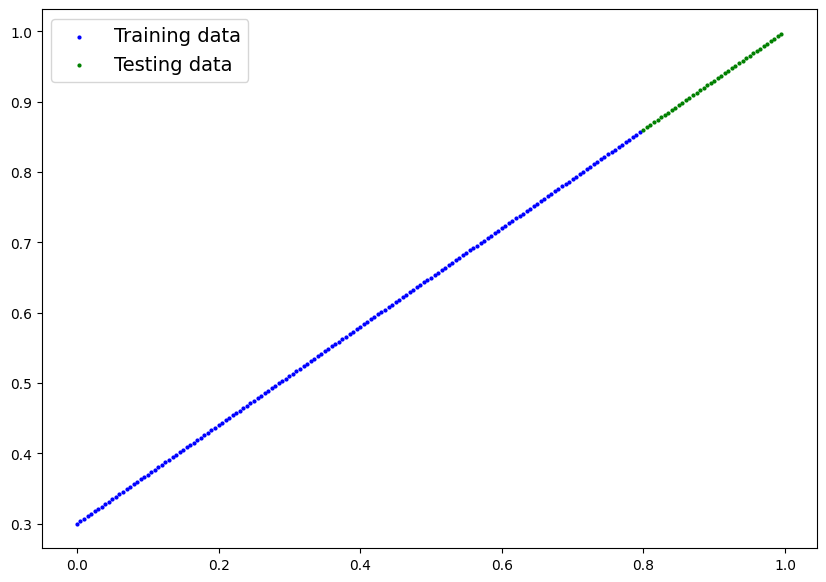

In [82]:
plot_predictions()

## 2. Build a model

What out model does:
* Starts with random values (weight & bias)
* Looks at training data and adjust random values to better represent the ideal values (weights and bias we used to create data)

How does it do it?

Through two main algorithms:
1. Gradient descent
2. Backpropagation

In [83]:
# Create a linear regression model clas

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=float))
        
    # Forward method to define the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.bias 

### Pytorch model building essentials

* nn.Module contains the larger building blocks (layers)
* nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
* forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)
* torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data

### Checking the contents of our model

We can check the model parameters or what's inside our model using .parameters()

In [100]:
# Create a manual seed
torch.manual_seed(42)

# Create an instance of model
model_0 = LinearRegressionModel()

# Check out the parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor([0.1288], dtype=torch.float64, requires_grad=True)]

In [101]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], dtype=torch.float64)),
             ('bias', tensor([0.1288], dtype=torch.float64))])

### Making predictions using `torch.inference_mode()`

To check out model's predictive power, let's see how well it predicts `y_test` based on `X_test`.

When we pass data into our model, it is going to run it through the forward() method.

In [102]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.3998],
        [0.4015],
        [0.4032],
        [0.4049],
        [0.4066],
        [0.4083],
        [0.4099],
        [0.4116],
        [0.4133],
        [0.4150],
        [0.4167],
        [0.4184],
        [0.4200],
        [0.4217],
        [0.4234],
        [0.4251],
        [0.4268],
        [0.4285],
        [0.4301],
        [0.4318],
        [0.4335],
        [0.4352],
        [0.4369],
        [0.4386],
        [0.4402],
        [0.4419],
        [0.4436],
        [0.4453],
        [0.4470],
        [0.4487],
        [0.4503],
        [0.4520],
        [0.4537],
        [0.4554],
        [0.4571],
        [0.4588],
        [0.4604],
        [0.4621],
        [0.4638]], dtype=torch.float64)

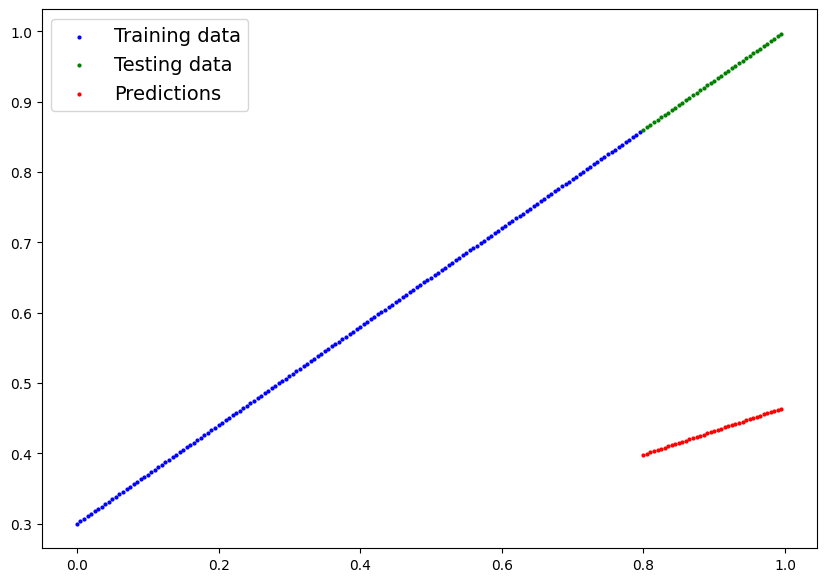

In [87]:
# Plot predictions
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some *unknown* paramaters to some *known* parameters, or from a poor
representation of data to a better representatiion of data.

* **Loss function:** A function to measure how wrong your model's predictions are to the ideal outputs, lower is better.
* **Optimizer:** Takes into account the loss of a model and adjusts the model's parameters (weights and bias) to improve the loss function.

In [103]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367], dtype=torch.float64)),
             ('bias', tensor([0.1288], dtype=torch.float64))])

In [104]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (stochastic gradient descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01 #lr - learning rate
                            )

### Building a training loop and a testing loop in Pytorch

Things needed:
0. Loop through data
1. Forward pass (this involves data moving through our model's `forward()` method) to make predictions on data - also called forward propagation
2. Calculate the loss (compared forward pass predictions to ground truth labels).
3. Optimizer zero grad
4. Loss backward - move backwards through network to calculate the gradients of each of the parameters of our model wrt the loss. (**backpropagation**)
5. Optimizer step - use the optimizer to adjust our model's parameters to try and improve the loss. (**gradient descent**)


In [105]:
# An epoch is one loop through the data (a hyperparameter because we set it ourselves)
epochs = 200

# Track different values
epoch_count = []
loss_values = []
test_loss_values = []

### Training
# 0. Loop through the data
for epoch in range(epochs):
    #Set the model to training mode
    model_0.train() #sets all params that require gradients to require gradients
    
    # 1. Forward pass
    y_pred = model_0(X_train)
    
    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)
    
    # 3. Optimizer
    optimizer.zero_grad()
    
    # 4. Perform backpropagation on the loss wrt to model params
    loss.backward()
    
    # 5. Step the optimizer (gradient descent)
    optimizer.step()
     
    ### Testing
    model_0.eval() #turns off gradient tracking and different settings in the model not needed for evaluation/testing (dropout, batch norm layers)
    with torch.inference_mode(): #turns off gradient tracking 
        # 1. Do the forward pass
        test_pred = model_0(X_test)
        
        #2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)
    
    if epoch % 10 == 0:    
    # Print out what's happening  
        epoch_count.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Test: {loss} | Test loss: {test_loss}")
        print(model_0.state_dict())

Epoch: 0 | Test: 0.3156061863784328 | Test loss: 0.48369344144942056
OrderedDict({'weights': tensor([0.3407], dtype=torch.float64), 'bias': tensor([0.1388], dtype=torch.float64)})
Epoch: 10 | Test: 0.1998055616544174 | Test loss: 0.3480178170216094
OrderedDict({'weights': tensor([0.3804], dtype=torch.float64), 'bias': tensor([0.2388], dtype=torch.float64)})
Epoch: 20 | Test: 0.08974413562279607 | Test loss: 0.21736864571514253
OrderedDict({'weights': tensor([0.4200], dtype=torch.float64), 'bias': tensor([0.3339], dtype=torch.float64)})
Epoch: 30 | Test: 0.05273209576387546 | Test loss: 0.14357052428127778
OrderedDict({'weights': tensor([0.4532], dtype=torch.float64), 'bias': tensor([0.3779], dtype=torch.float64)})
Epoch: 40 | Test: 0.045055751754306705 | Test loss: 0.11229136051268915
OrderedDict({'weights': tensor([0.4769], dtype=torch.float64), 'bias': tensor([0.3879], dtype=torch.float64)})
Epoch: 50 | Test: 0.04128200080334653 | Test loss: 0.09775120147378794
OrderedDict({'weights'

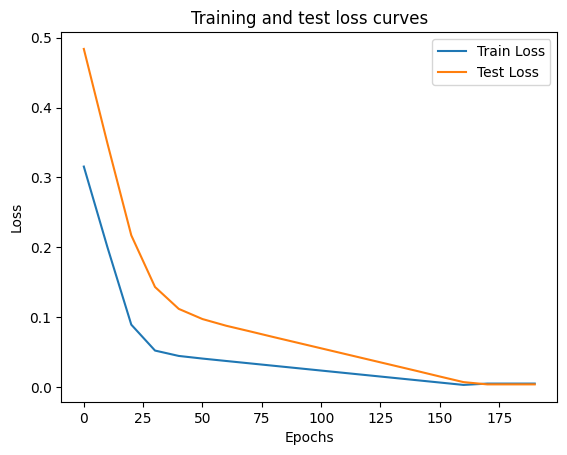

In [112]:
# Plot loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, test_loss_values, label="Test Loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

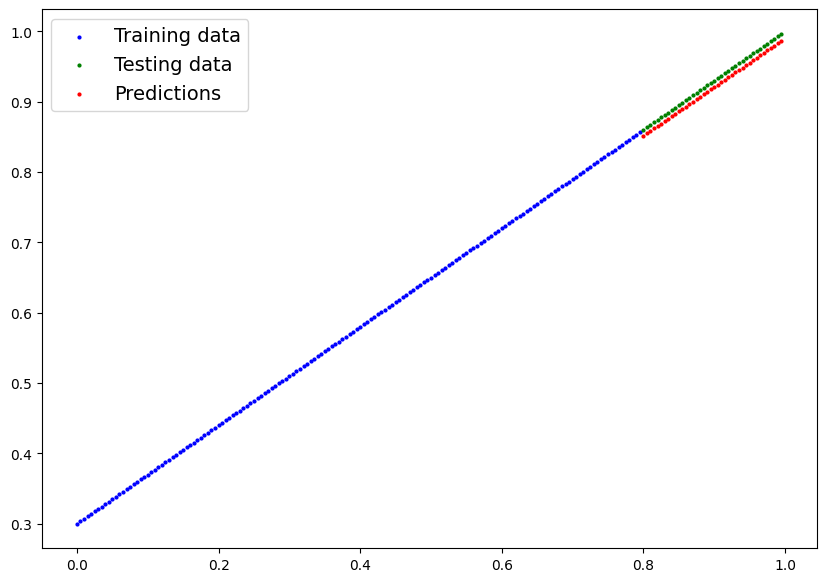

In [106]:
with torch.inference_mode():
    y_preds_new = model_0(X_test)
    
plot_predictions(predictions=y_preds_new)